In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import PIL

import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [41]:
# network parameters
width = 128
height = 128
latent_dim = 200


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
x = GaussianNoise(0.5)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(h*w*c, activation='relu')(latent_inputs)
x = Reshape((h,w,c))(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='sigmoid', padding='same')(x)


# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise_5 (GaussianNoise (None, 128, 128, 3)  0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 64, 16)   448         gaussian_noise_5[0][0]           
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 64, 64, 16)   64          conv2d_45[0][0]                  
____________________________________________________________________________________________

In [42]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= width*height # common practice to scale with w*h
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

#Beta VAE warmup
beta = K.variable(value=0.0)
def warmup(epoch, warmup_til_epoch=50):
    value = (epoch/warmup_til_epoch) * (warmup_til_epoch <= 50.0) + 1.0 * (warmup_til_epoch > 50.0)
    print(" beta:", value)
    K.set_value(beta, value)
    
from tensorflow.keras.callbacks import LambdaCallback
wu_cb = LambdaCallback(on_epoch_end=lambda epoch, log: warmup(epoch))


vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
optimizer = Adam(0.0005)
vae.compile(optimizer='adam')

In [43]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.0,
    horizontal_flip=False)

# validation_generator = training_data_generator.flow_from_directory(
#    './Birds-200-2011/',
#     target_size=(width, height),
#     subset='validation',
#     batch_size=32,
#     class_mode='input')

training_generator = training_data_generator.flow_from_directory(
   './celeba/',
    target_size=(width, height),
    subset='training',
    shuffle=True,
    batch_size=32,
    class_mode='input')

Found 202599 images belonging to 1 classes.


In [107]:
import cv2
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)
X = data_loader('./CUB_200_2011/cleaned-birds/training')

In [44]:
epochs = 150

history_dict = vae.fit_generator(training_generator, epochs=epochs, callbacks=[wu_cb])
#history_dict = vae.fit(X, epochs=epochs,batch_size=32, shuffle=True,callbacks=[wu_cb])
history += history_dict.history['loss']

  ...
    to  
  ['...']
Train for 6332 steps
Epoch 1/150
6332/6332 [==============================] - 184s 29ms/step - loss: 361.0359
Epoch 2/150
6332/6332 [==============================] - 183s 29ms/step - loss: 308.4643
Epoch 3/150
6332/6332 [==============================] - 188s 30ms/step - loss: 299.9030
Epoch 4/150
6332/6332 [==============================] - 181s 29ms/step - loss: 295.3109
Epoch 5/150
6332/6332 [==============================] - 178s 28ms/step - loss: 292.4627
Epoch 6/150
6332/6332 [==============================] - 179s 28ms/step - loss: 290.3528
Epoch 7/150
6332/6332 [==============================] - 180s 28ms/step - loss: 288.6945
Epoch 8/150
6332/6332 [==============================] - 178s 28ms/step - loss: 287.0460
Epoch 9/150
6332/6332 [==============================] - 179s 28ms/step - loss: 285.8450
Epoch 10/150
6332/6332 [==============================] - 180s 28ms/step - loss: 284.6317
Epoch 11/150
6332/6332 [==============================] - 180s 

6332/6332 [==============================] - 180s 28ms/step - loss: 275.6550
Epoch 49/150
6332/6332 [==============================] - 180s 28ms/step - loss: 275.5386
Epoch 50/150
6332/6332 [==============================] - 179s 28ms/step - loss: 275.4596
Epoch 51/150
6332/6332 [==============================] - 179s 28ms/step - loss: 275.3936
Epoch 52/150
6332/6332 [==============================] - 179s 28ms/step - loss: 275.3771
Epoch 53/150
6332/6332 [==============================] - 177s 28ms/step - loss: 275.2388
Epoch 54/150
6332/6332 [==============================] - 179s 28ms/step - loss: 275.2038
Epoch 55/150
6332/6332 [==============================] - 178s 28ms/step - loss: 275.1302
Epoch 56/150
6332/6332 [==============================] - 179s 28ms/step - loss: 275.0503
Epoch 57/150
6332/6332 [==============================] - 176s 28ms/step - loss: 275.0133
Epoch 58/150
6332/6332 [==============================] - 178s 28ms/step - loss: 274.9517
Epoch 59/150
6332/6332 

6332/6332 [==============================] - 178s 28ms/step - loss: 273.4451
Epoch 97/150
6332/6332 [==============================] - 179s 28ms/step - loss: 273.3747
Epoch 98/150
6332/6332 [==============================] - 178s 28ms/step - loss: 273.3569
Epoch 99/150
6332/6332 [==============================] - 178s 28ms/step - loss: 273.2875
Epoch 100/150
6332/6332 [==============================] - 177s 28ms/step - loss: 273.3306
Epoch 101/150
6332/6332 [==============================] - 177s 28ms/step - loss: 273.3008
Epoch 102/150
6332/6332 [==============================] - 176s 28ms/step - loss: 273.2325
Epoch 103/150
6332/6332 [==============================] - 176s 28ms/step - loss: 273.3031
Epoch 104/150
6332/6332 [==============================] - 176s 28ms/step - loss: 273.2207
Epoch 105/150
6332/6332 [==============================] - 177s 28ms/step - loss: 273.1697
Epoch 106/150
6332/6332 [==============================] - 177s 28ms/step - loss: 273.1382
Epoch 107/150
63

6332/6332 [==============================] - 176s 28ms/step - loss: 272.3423
Epoch 145/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.2797
Epoch 146/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.3729
Epoch 147/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.3197
Epoch 148/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.2271
Epoch 149/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.2841
Epoch 150/150
6332/6332 [==============================] - 176s 28ms/step - loss: 272.2916


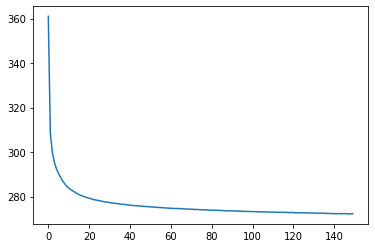

In [45]:
plt.plot(history)

In [15]:
imgs = training_generator.next()[0]

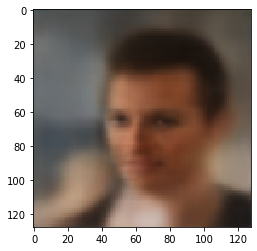

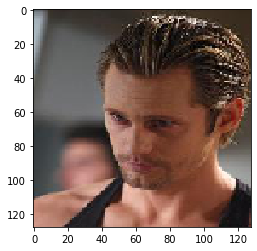

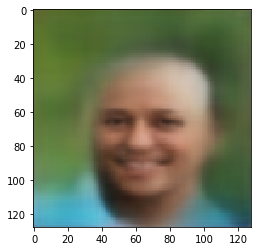

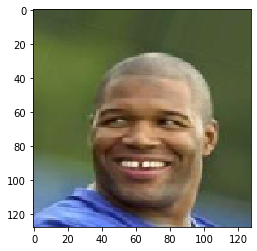

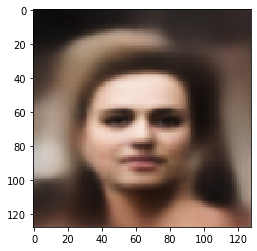

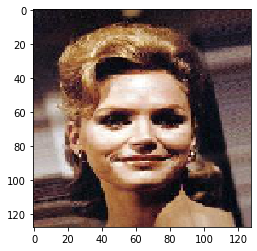

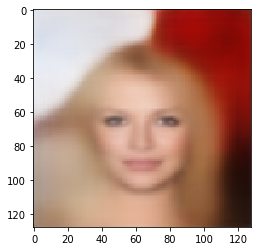

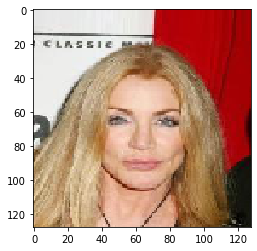

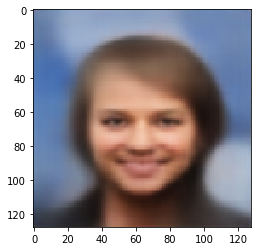

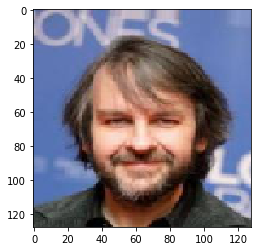

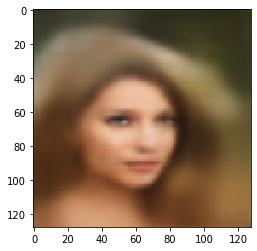

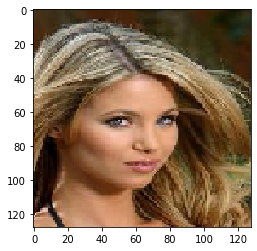

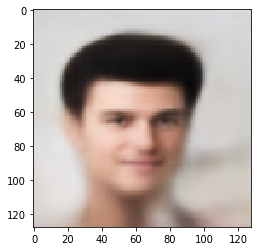

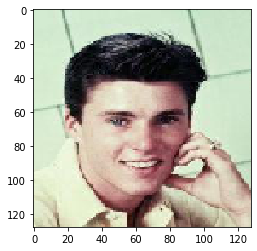

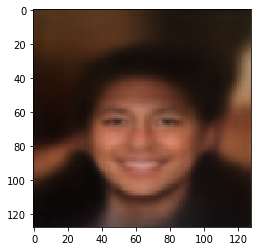

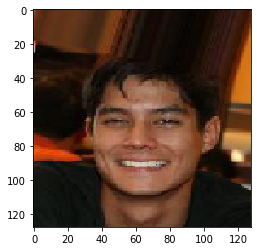

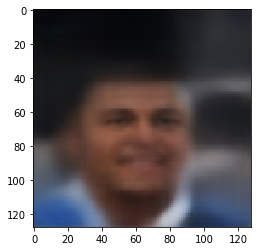

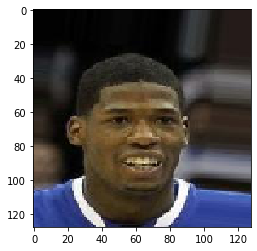

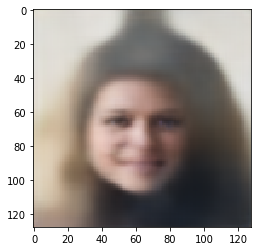

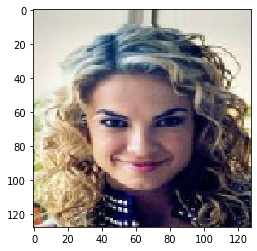

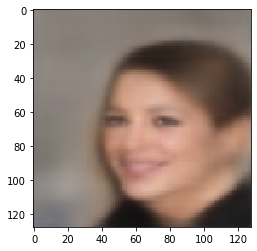

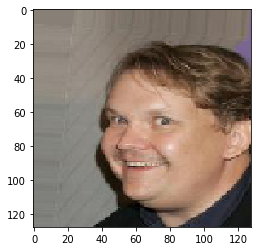

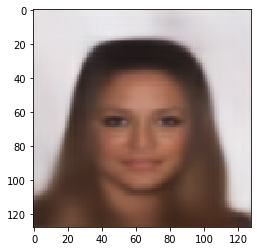

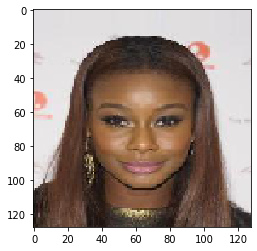

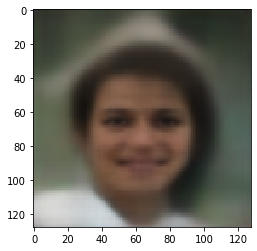

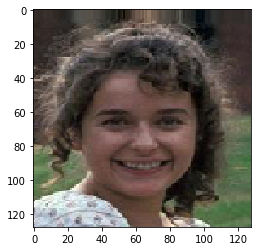

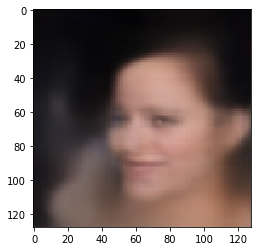

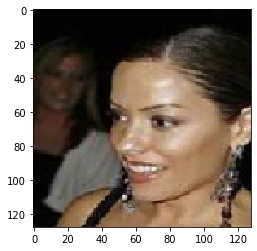

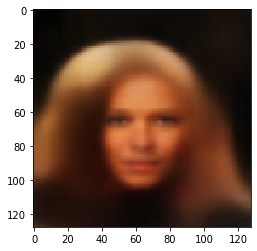

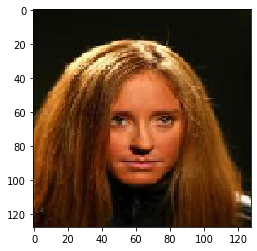

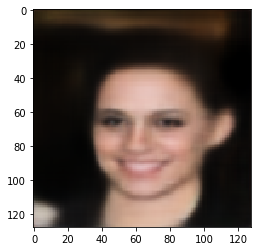

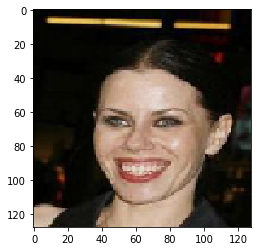

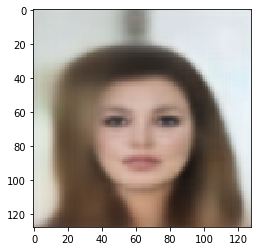

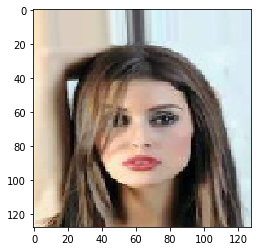

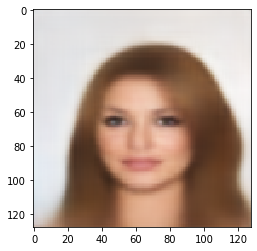

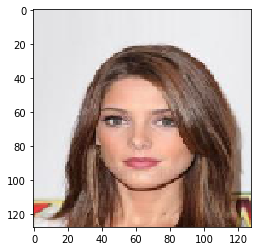

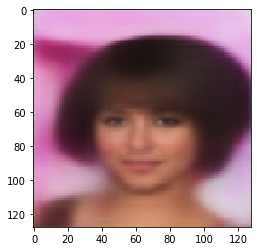

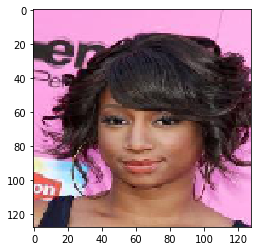

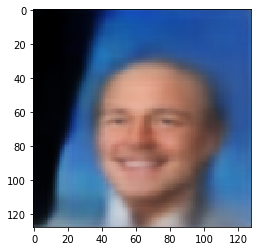

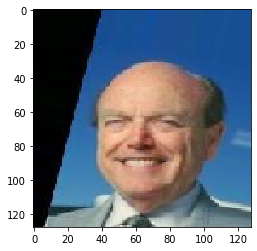

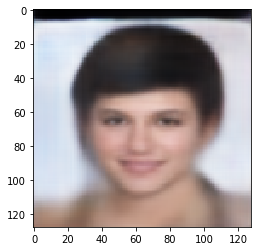

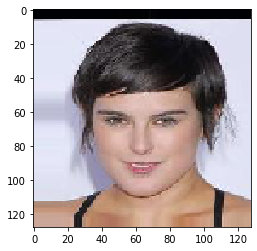

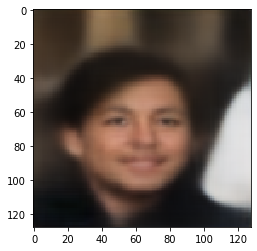

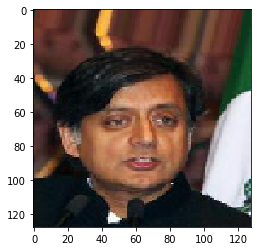

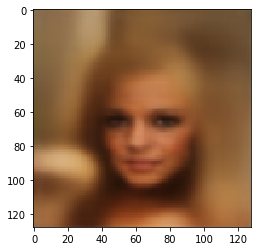

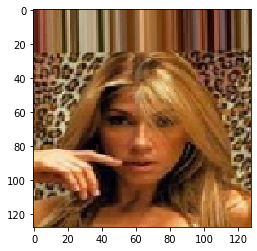

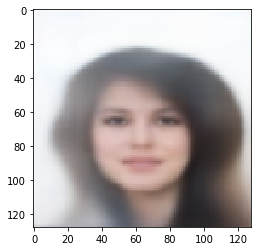

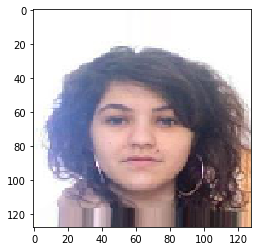

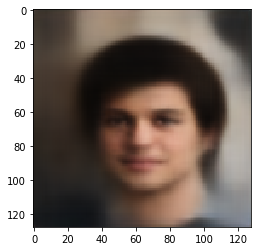

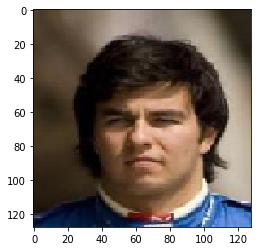

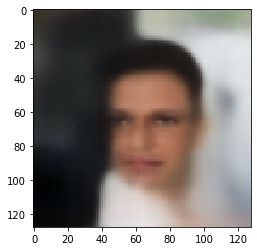

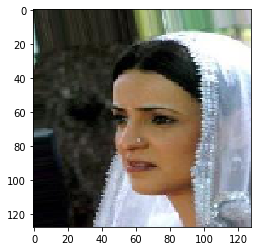

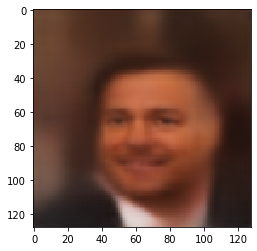

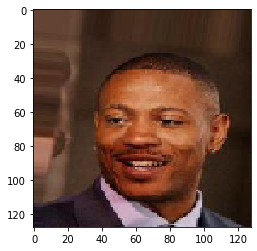

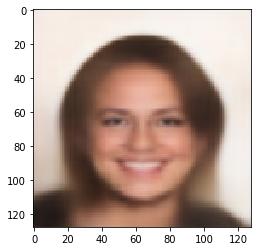

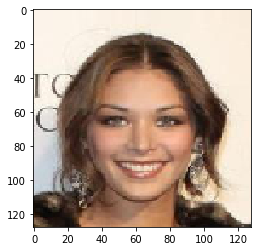

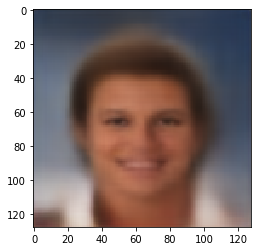

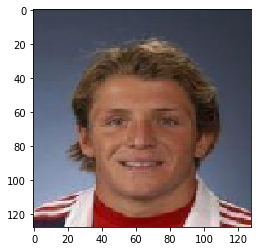

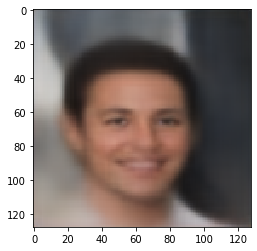

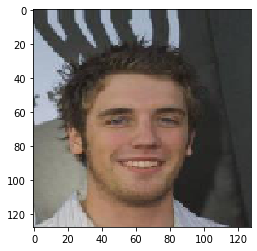

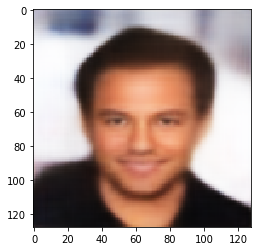

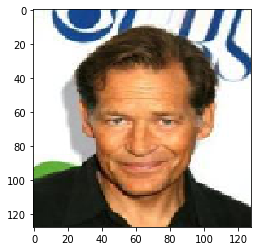

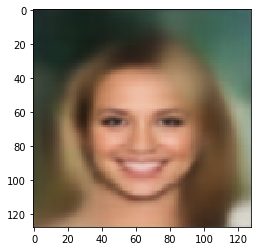

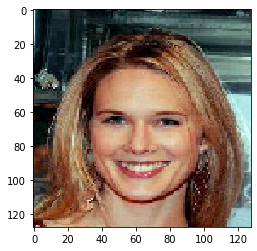

In [46]:
for idx in range(32):
    generated = vae.predict(np.array([imgs[idx]]))[0]
    actual = imgs[idx]

    plt.imshow(generated)
    plt.show()
    plt.imshow(actual)
    plt.show()

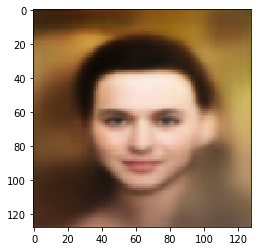

In [55]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict(np.array([s]))[0])
plt.show()

In [56]:
vae.save('beta50DVAE-150.h5', save_format='tf')